# Load Libraries and Functions

In [1]:
# System, Data, Time, and Spec Libraries
import os
import pandas as pd
import time
import random
from datetime import datetime, timedelta
import numpy as np
from line_profiler import LineProfiler  # Code peformance

profiler = LineProfiler()
import warnings

warnings.filterwarnings("ignore")
import csv

# pd.set_option('display.max_colwidth', None)
import multiprocess as mp

num_cores = mp.cpu_count()

# Data Visualization Libraries
import matplotlib.pyplot as plt
from tabulate import tabulate
import plotly.express as px
import seaborn as sns

# from pandas.io.json import json_normalize  # Older version
from pandas import json_normalize  # Newer version
from pandas.plotting import parallel_coordinates
from IPython.display import display, Image
import shap
import streamlit as st


# Natural Language Processing Libraries
import json
import requests
import xml.etree.ElementTree as ET
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import words
import string
import nltk
from collections import OrderedDict
from nltk.tokenize import word_tokenize
from pandas import json_normalize
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
from nltk.util import ngrams
from nltk.corpus import stopwords
from string import punctuation

punctuation = set(punctuation)
punctuation.update({"_", "-", "‘"})
english_words = set(words.words())
from fuzzywuzzy import process

# nltk.download('words')
# nltk.download('punkt')
# nltk.download('stopwords')

# SQL Interface Libraries
import pymysql as mysql
import mysql.connector
import pyodbc
import sqlite3
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy import event
from string import punctuation

# Machine Learning Libraries
import scipy.stats as stats
from scipy.stats import zscore
from scipy.stats import yeojohnson
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.impute import KNNImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
from sklearn.metrics import classification_report, mean_squared_error, f1_score
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from dmba import (
    classificationSummary,
    AIC_score,
    BIC_score,
    plotDecisionTree,
    gainsChart,
)
from scikitplot.metrics import plot_lift_curve, plot_cumulative_gain
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.metrics import specificity_score, sensitivity_score
from imblearn.under_sampling import RandomUnderSampler
from scikitplot.metrics import plot_lift_curve
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn import preprocessing
from sklearn import tree
from sklearn.model_selection import cross_val_score
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import KFold
from dmba import stepwise_selection, classificationSummary, backward_elimination
from sklearn.decomposition import PCA
from sklearn.utils.random import sample_without_replacement
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import joblib

# Importing Custom Functions
import nbimporter
from Functions import (
    nan_info,
    get_model_coefficients_and_odds,
    evaluate_model,
    top_drug_comparison,
)
from Functions import display_model_metrics_table

### SQL Password

In [ ]:
PASSWORD = "PASSWORD"

## Investigate number of records in each database table

In [ ]:
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

cursor = connection.cursor()
sql_query = """SELECT COUNT(*) FROM patient_reactions"""


cursor.execute(sql_query)
result = cursor.fetchall()
column_names = [i[0] for i in cursor.description]


result_query_df = pd.DataFrame(result, columns=column_names)

cursor.close()
connection.close()

result_query_df

# Get Dataset from SQL Database

In [ ]:
# Connect to the MySQL server
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

# Create a cursor object
cursor = connection.cursor()

# Query data from SQL

In [ ]:
start_time = time.time()

connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

# temp removed a.expedited,

cursor = connection.cursor()
sql_query = """SELECT 
d.med_product,
d.event_id,
d.manu_num,
a.serious_outcome,
a.age,
a.sex,
a.year,
a.weight,
a.report_source,
r.outcome,
d.ndc9,
p.unit_price
FROM adverse_events a 

INNER JOIN patient_reactions r ON a.event_id = r.event_id
INNER JOIN patient_drugs d ON a.event_id = d.event_id
LEFT JOIN prices p ON d.ndc9 = p.ndc9
ORDER BY a.event_id DESC
"""
cursor.execute(sql_query)
result = cursor.fetchall()
column_names = [i[0] for i in cursor.description]
master_query_df = pd.DataFrame(result, columns=column_names)

cursor.close()
connection.close()


end_time = time.time()
execution_time = end_time - start_time
print(execution_time)


master_query_df = master_query_df.drop_duplicates()


master_query_df["unit_price"] = master_query_df["unit_price"].replace({None: np.nan})

# Calculate the median of the 'unit_price' column, ignoring NaN values
median_unit_price = master_query_df["unit_price"].median()

# Replace NaN values in 'unit_price' with the calculated median
master_query_df["unit_price"] = master_query_df["unit_price"].fillna(median_unit_price)
# master_query_df = master_query_df[master_query_df['expedited'] != 5]

master_query_df.head(10)


master_query_df.to_csv(
    "../DataLibrary/FinalModelInput/result_query_2024_withImputedprices.csv"
)

In [ ]:
master_query_df.shape

In [ ]:
master_query_df.head()

# Preparation for Data Split

In [2]:
master_query_df = pd.read_csv(
    "../DataLibrary/FinalModelInput/result_query_2024_withImputedprices.csv"
)

### Define numerical, text, and categorical variables

In [3]:
cats = ["sex", "report_source", "ndc9"]
nums = ["weight", "age", "unit_price"]
all_vars = cats + nums

# Define outcome as categorical
master_query_df["serious_outcome"] = master_query_df["serious_outcome"].astype(
    "category"
)

master_query_df.head()

,Unnamed: 0,med_product,event_id,manu_num,serious_outcome,age,sex,year,weight,report_source,outcome,ndc9,unit_price
0,0,['xolair'],20885,1,1,25,1,2024,95,3,Unknown,502420040,0.48535
1,4,['xolair'],20885,1,1,25,1,2024,95,3,Recovering,502420040,0.48535
2,14,['xolair'],20885,1,1,25,1,2024,95,3,NotRecovered,502420040,0.48535
3,17,['xolair'],20885,1,1,25,1,2024,95,3,Recovered,502420040,0.48535
4,846,['aspirin'],20885,153,1,25,1,2024,95,3,Unknown,476820456,0.48535


# Split Data into Training/Validation/Testing

In [4]:
master_query_df.shape

(83307, 13)

### Make a Subset of the Dataset for Initial Model Training

In [5]:
# Split the data into features (X) and the target variable (y).
X = master_query_df[all_vars]

# Define outcome variable
y = master_query_df[["serious_outcome"]]

# Split data
X_train, X_rest, y_train, y_rest = train_test_split(
    X, y, train_size=0.8, random_state=2
)
X_val, X_test, y_val, y_test = train_test_split(
    X_rest, y_rest, test_size=0.5, random_state=2
)

In [6]:
X_train.shape, y_train.shape

((66645, 6), (66645, 1))

In [7]:
y_train.value_counts()

serious_outcome
1                  46637
2                  17317
0                   2691
Name: count, dtype: int64

In [8]:
X_val.shape, y_val.shape

((8331, 6), (8331, 1))

In [9]:
X_test.shape, y_test.shape

((8331, 6), (8331, 1))

In [10]:
X_test.head()

,sex,report_source,ndc9,weight,age,unit_price
13607,2,2,476820456,49,14,0.48535
37526,1,1,837030534,83,71,0.48535
27780,2,3,70300241,68,44,0.48535
73064,2,1,6050504317,36,80,0.48535
51207,1,1,662150501,80,60,0.48535


# Transformation Pipeline

## Encode Categorical Variables (other than drugs) & Standardize Numerical Variables

In [11]:
# Initialize encoders
encoder = OneHotEncoder(drop="if_binary", handle_unknown="ignore")
scaler = StandardScaler()

In [12]:
# Fit the encoder on X so all possible categories are captured, even if they are only in training or testing
encoder.fit(X_train[cats])
scaler.fit(X_train[nums])

StandardScaler()

In [13]:
# Initialize encoders
encoder = OneHotEncoder(drop="if_binary", sparse_output=False, handle_unknown="ignore")
scaler = StandardScaler()

# Fit the encoder on X so all possible categories are captured, even if they are only in training or testing
encoder.fit(X[cats])
scaler.fit(X_train[nums])

# Save the encoder and scaler to disk for streamlit
# Create Directory for Model Storage and Apps
os.makedirs("Pretrained_Model_and_Apps", exist_ok=True)
joblib.dump(encoder, "Pretrained_Model_and_Apps/encoder.joblib")
joblib.dump(scaler, "Pretrained_Model_and_Apps/scaler.joblib")


def transform_data(data):
    # Apply one-hot encoding to categorical features
    encoded_features = encoder.transform(data[cats])
    encoded_df = pd.DataFrame(
        encoded_features, columns=encoder.get_feature_names_out(cats)
    )

    # Apply standardization to numerical features
    standardized_features = scaler.transform(data[nums])
    standardized_df = pd.DataFrame(standardized_features, columns=nums)

    # Concatenate the standardized numerical features with the encoded categorical features
    return pd.concat(
        [
            data.drop(cats + nums, axis=1).reset_index(drop=True),
            standardized_df.reset_index(drop=True),
            encoded_df.reset_index(drop=True),
        ],
        axis=1,
    )

In [14]:
# Apply the transformation to all datasets

# Apply to training data after outcome balancing - need to save raw data components for streamlit first
# X_train_encoded = transform_data(X_train)

X_val_encoded = transform_data(X_val)
X_test_encoded = transform_data(X_test)
X_test_encoded.head()

,weight,age,unit_price,sex_2,report_source_1,report_source_2,report_source_3,ndc9_200152,ndc9_200213,ndc9_202980,...,ndc9_7359409301,ndc9_7467605902,ndc9_7632901912,ndc9_7632903318,ndc9_7632908261,ndc9_7948100090,ndc9_8076200021,ndc9_8215400449,ndc9_8224301001,ndc9_8322200200
0,-1.067765,-2.049919,-0.101208,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.423929,0.785213,-0.101208,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.234171,-0.557744,-0.101208,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.638119,1.232865,-0.101208,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.292309,0.238082,-0.101208,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# X_test_encoded.to_csv('C://Users/halee/Downloads/X_test_encoded.csv')

## Resampling Techniques - UnderSampling of Training Set

In [16]:
y_train.value_counts()

serious_outcome
1                  46637
2                  17317
0                   2691
Name: count, dtype: int64

In [17]:
# Create a RandomUnderSampler instance with a specified random seed and sampling strategy
# Define the sampling strategy to balance all classes
sampling_n = {
    0: y_train.value_counts()[0],
    1: y_train.value_counts()[0],
    2: y_train.value_counts()[0],
}
rus = RandomUnderSampler(random_state=1, sampling_strategy=sampling_n)

# Perform random under-sampling on the training dataset
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

In [18]:
X_train_under.shape, y_train_under.shape

((8073, 6), (8073, 1))

In [19]:
y_train_under.value_counts()

serious_outcome
0                  2691
1                  2691
2                  2691
Name: count, dtype: int64

### Save components of raw training data for pretrained model deployment in streamlit

In [49]:
# Initialize and fit the scalers
# age_scaler = StandardScaler().fit(X_train_under[['age']])
# weight_scaler = StandardScaler().fit(X_train_under[['weight']])
# price_scaler = StandardScaler().fit(X_train_under[['unit_price']])

# Save the scalers
# joblib.dump(age_scaler, 'Pretrained_Model_and_Apps/age_scaler.joblib')
# joblib.dump(weight_scaler, 'Pretrained_Model_and_Apps/weight_scaler.joblib')
# joblib.dump(price_scaler, 'Pretrained_Model_and_Apps/price_scaler.joblib')

# Save list of ndc9 codes
# ndc9_codes = master_query_df['ndc9'].tolist()
# joblib.dump(ndc9_codes, 'Pretrained_Model_and_Apps/ndc9_codes.joblib')

['Pretrained_Model_and_Apps/ndc9_codes.joblib']

### Transform Features of Balanced Training Dataset

In [20]:
X_train_encoded = transform_data(X_train_under)
X_train_encoded.shape
X_train_encoded.head()

,weight,age,unit_price,sex_2,report_source_1,report_source_2,report_source_3,ndc9_200152,ndc9_200213,ndc9_202980,...,ndc9_7359409301,ndc9_7467605902,ndc9_7632901912,ndc9_7632903318,ndc9_7632908261,ndc9_7948100090,ndc9_8076200021,ndc9_8215400449,ndc9_8224301001,ndc9_8322200200
0,0.950410,0.586256,-0.101208,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.248436,-0.309048,-0.101208,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.248436,-0.856179,-0.101208,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.520763,-0.607483,-0.101208,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.047244,0.138604,-0.101208,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
X_train_under = X_train_encoded

# Multiclass Classification Model Training

## White Box Models

### Logistic Regression L1 Regularization

#### Generate and Fit Model on Training Data

In [96]:
log_l1 = LogisticRegression(solver="saga", penalty="l1", random_state=1)
log_l1.fit(X_train_under, y_train_under)

LogisticRegression(penalty='l1', random_state=1, solver='saga')

#### Fit Model on Testing Data, Model Performance Metrics

In [97]:
model_name = "log_l1"

# Run model on test data, generate confusion matrix, save y_pred
log_l1_metrics_df, log_l1_img_path, log_l1_y_pred = evaluate_model(
    log_l1, X_test_encoded, y_test, labels=[0, 1, 2], model_name=model_name
)

log_l1_metrics_df.head()

,model,class,accuracy,precision,recall,f1_score,specificity
0,log_l1,0,0.664,0.397,0.801,0.531,0.991
1,log_l1,1,0.664,0.829,0.671,0.742,0.468
2,log_l1,2,0.664,0.459,0.622,0.528,0.850


#### Get Probabilities for AUC curve

In [98]:
log_l1_y_pred_proba = log_l1.predict_proba(X_test_encoded)  # This should be a 2D array

#### View Classification Matrix

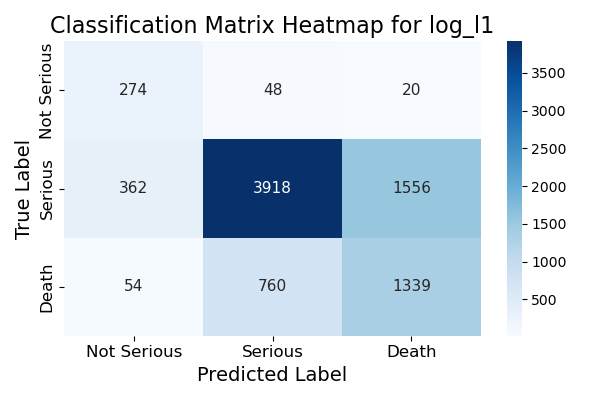

In [99]:
display(Image(filename=log_l1_img_path))

#### Other Model Metrics - Model Coefficient Odds for Each Outcome

In [100]:
coefficients_and_odds = get_model_coefficients_and_odds(X_train_under, log_l1)
for outcome, df in coefficients_and_odds.items():
    print(f"Top features for {outcome}:")
    print(df)

Top features for Non-Serious:
             Feature   LogOdds        Odds
0          Intercept -0.686550    0.503310
104     ndc9_2405911  4.750690  115.664103
1285  ndc9_684620226  3.527110   34.025489
948   ndc9_593530400  3.454872   31.654247
530   ndc9_119940011  3.406307   30.153688
753   ndc9_502420150  3.394046   29.786229
Top features for Serious:
             Feature   LogOdds      Odds
0          Intercept  0.622085  1.862807
103     ndc9_2405908 -2.618008  0.072948
1519  ndc9_782060145  1.543979  4.683189
884   ndc9_555130137 -1.421495  0.241353
1203  ndc9_663020206 -1.381644  0.251165
420    ndc9_40906660  1.328369  3.774882
Top features for Death:
             Feature   LogOdds      Odds
0          Intercept  0.064465  1.066588
104     ndc9_2405911 -2.793017  0.061236
688   ndc9_461220166  2.145949  8.550151
1034  ndc9_623320487  2.107790  8.230033
1285  ndc9_684620226 -2.018328  0.132878
802   ndc9_507420279  1.939202  6.953202


### Logistic Regression L2 Regularization

#### Generate and Fit Model on Training Data

In [101]:
log_l2 = LogisticRegression(solver="saga", penalty="l2", random_state=1)
log_l2.fit(X_train_under, y_train_under)

LogisticRegression(random_state=1, solver='saga')

#### Fit Model on Testing Data, Model Performance Metrics

In [102]:
model_name = "log_l2"

# Run model on test data, generate confusion matrix, save y_pred
log_l2_metrics_df, log_l2_img_path, log_l2_y_pred = evaluate_model(
    log_l2, X_test_encoded, y_test, labels=[0, 1, 2], model_name=model_name
)

log_l2_metrics_df.head()

,model,class,accuracy,precision,recall,f1_score,specificity
0,log_l2,0,0.661,0.370,0.822,0.510,0.992
1,log_l2,1,0.661,0.845,0.648,0.734,0.467
2,log_l2,2,0.661,0.465,0.668,0.548,0.863


#### Get Probabilities for AUC Curve

In [103]:
log_l2_y_pred_proba = log_l2.predict_proba(X_test_encoded)  # This should be a 2D array

#### View Classification Matrix

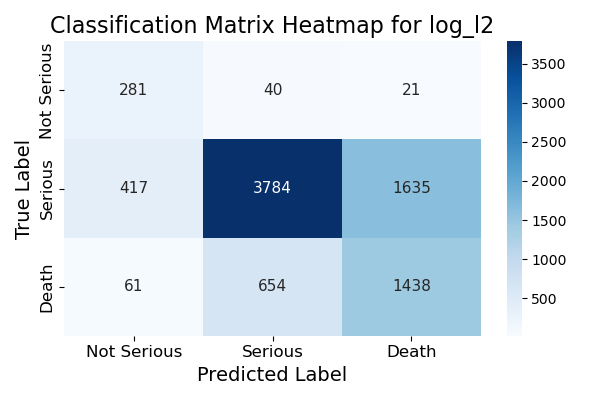

In [104]:
display(Image(filename=log_l2_img_path))

#### Other Metrics - Model Coefficient Odds for Each Outcome

In [105]:
coefficients_and_odds = get_model_coefficients_and_odds(X_train_under, log_l2)
for outcome, df in coefficients_and_odds.items():
    print(f"Top features for {outcome}:")
    print(df)

Top features for Non-Serious:
             Feature   LogOdds       Odds
0          Intercept -0.488700   0.613424
104     ndc9_2405911  3.891035  48.961519
1285  ndc9_684620226  2.766092  15.896394
753   ndc9_502420150  2.763339  15.852681
948   ndc9_593530400  2.682701  14.624539
530   ndc9_119940011  2.620639  13.744501
Top features for Serious:
            Feature   LogOdds      Odds
0         Intercept  0.536397  1.709836
103    ndc9_2405908 -1.978682  0.138251
530  ndc9_119940011 -1.426484  0.240152
104    ndc9_2405911 -1.381133  0.251294
647  ndc9_423880023 -1.328649  0.264835
884  ndc9_555130137 -1.328017  0.265002
Top features for Death:
             Feature   LogOdds      Odds
0          Intercept -0.047698  0.953422
104     ndc9_2405911 -2.509902  0.081276
1285  ndc9_684620226 -1.903788  0.149003
141     ndc9_6900187 -1.728157  0.177611
688   ndc9_461220166  1.698647  5.466548
1034  ndc9_623320487  1.667984  5.301471


### Logistic Regression Elastic Net

#### Grid Search

In [106]:
param_grid = {
    "l1_ratio": [
        i / 9 for i in range(10)
    ],  # 10 values from 0 to 1 (0, 0.1, 0.2, ..., 1.0)
    "C": [0.01, 0.1, 1, 10, 100],  # Different strengths of regularization
}

# Initialize the Logistic Regression model with Elastic Net penalty
log_reg_elasticnet = LogisticRegression(
    penalty="elasticnet",  # Use Elastic Net regularization
    solver="saga",  # Solver that supports Elastic Net
    random_state=1,
)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=log_reg_elasticnet,
    param_grid=param_grid,
    scoring="accuracy",  # Or another metric of choice
    cv=5,  # Number of cross-validation folds
    n_jobs=-1,  # Use all available CPUs
)

# Fit GridSearchCV to the training data
grid_search.fit(X_train_under, y_train_under.values.ravel())

# Extract and print the best parameters and best score from grid search
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

best_score = grid_search.best_score_
print(f"Best cross-validation score: {best_score:.3f}")

# Get the best model
elastic_net = grid_search.best_estimator_

Best parameters: {'C': 10, 'l1_ratio': 0.0}
Best cross-validation score: 0.702


#### Generate and Fit Model on Training Data

In [107]:
elastic_net.fit(X_train_under, y_train_under)

LogisticRegression(C=10, l1_ratio=0.0, penalty='elasticnet', random_state=1,
                   solver='saga')

#### Fit Model on Testing Data, Model Performance Metrics

In [108]:
model_name = "elastic_net"

# Run model on test data, generate confusion matrix, save y_pred
elastic_net_metrics_df, elastic_net_img_path, elastic_net_y_pred = evaluate_model(
    elastic_net, X_test_encoded, y_test, labels=[0, 1, 2], model_name=model_name
)

elastic_net_metrics_df.head()

,model,class,accuracy,precision,recall,f1_score,specificity
0,elastic_net,0,0.657,0.347,0.836,0.490,0.993
1,elastic_net,1,0.657,0.847,0.641,0.729,0.464
2,elastic_net,2,0.657,0.469,0.674,0.553,0.866


#### Get Probabilities for AUC

In [109]:
elastic_net_y_pred_proba = elastic_net.predict_proba(
    X_test_encoded
)  # This should be a 2D array

#### View Classification Matrix

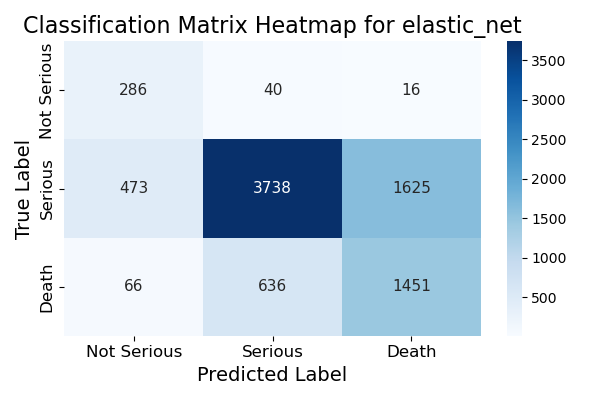

In [110]:
display(Image(filename=elastic_net_img_path))

#### Other Metrics - Model Coefficient Odds for Each Outcome

In [111]:
coefficients_and_odds = get_model_coefficients_and_odds(X_train_under, elastic_net)
for outcome, df in coefficients_and_odds.items():
    print(f"Top features for {outcome}:")
    print(df)

Top features for Non-Serious:
             Feature   LogOdds       Odds
0          Intercept -0.512363   0.599078
104     ndc9_2405911  4.447400  85.404565
530   ndc9_119940011  3.308062  27.332112
948   ndc9_593530400  3.299762  27.106175
1285  ndc9_684620226  3.271554  26.352259
304    ndc9_17300909  3.109717  22.414702
Top features for Serious:
             Feature   LogOdds      Odds
0          Intercept  0.543165  1.721446
103     ndc9_2405908 -2.722434  0.065715
530   ndc9_119940011 -1.918504  0.146826
884   ndc9_555130137 -1.878391  0.152836
1203  ndc9_663020206 -1.805994  0.164311
1519  ndc9_782060145  1.771940  5.882254
Top features for Death:
             Feature   LogOdds      Odds
0          Intercept -0.030802  0.969668
104     ndc9_2405911 -3.310082  0.036513
1285  ndc9_684620226 -2.579164  0.075837
948   ndc9_593530400 -2.244345  0.105997
688   ndc9_461220166  2.219195  9.199924
141     ndc9_6900187 -2.186006  0.112365


### Single Decision Tree

#### Grid Search

In [115]:
# Define a grid of hyperparameters to search for in tree
param_grid = {"max_depth": [5, 6, 7, 8, 9, 10], "min_samples_leaf": [1, 2, 3, 4, 5, 6]}
# Create a GridSearchCV object using and the defined parameter grid
tree1_search = GridSearchCV(
    DecisionTreeClassifier(random_state=1), param_grid, cv=10, n_jobs=-1
)

# Fit the GridSearchCV to the balanced training data to find the best hyperparameters
tree1_search.fit(X_train_under, y_train_under.values.ravel())

# Get the best hyperparameters found by the GridSearch
best_params = tree1_search.best_params_
print(f"Best parameters: {best_params}")

tree1 = tree1_search.best_estimator_

Best parameters: {'max_depth': 10, 'min_samples_leaf': 5}


#### Generate and Fit Model on Training Data

In [116]:
tree1.fit(X_train_under, y_train_under)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, random_state=1)

#### Fit Model on Testing Data, Model Performance Metrics

In [117]:
model_name = "tree1"

# Run model on test data, generate confusion matrix, save y_pred
tree1_metrics_df, tree1_img_path, tree1_y_pred = evaluate_model(
    tree1, X_test_encoded, y_test, labels=[0, 1, 2], model_name=model_name
)

tree1_metrics_df.head()

,model,class,accuracy,precision,recall,f1_score,specificity
0,tree1,0,0.744,0.248,0.635,0.356,0.983
1,tree1,1,0.744,0.856,0.776,0.814,0.570
2,tree1,2,0.744,0.672,0.675,0.673,0.887


#### Get Probabilities for AUC

In [118]:
tree1_y_pred_proba = tree1.predict_proba(X_test_encoded)  # This should be a 2D array

#### View Classification Matrix

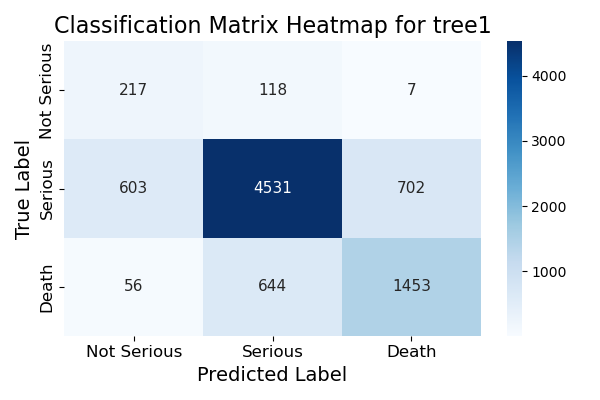

In [119]:
display(Image(filename=tree1_img_path))

#### Other Metrics - Feature Importance and Tree Structure

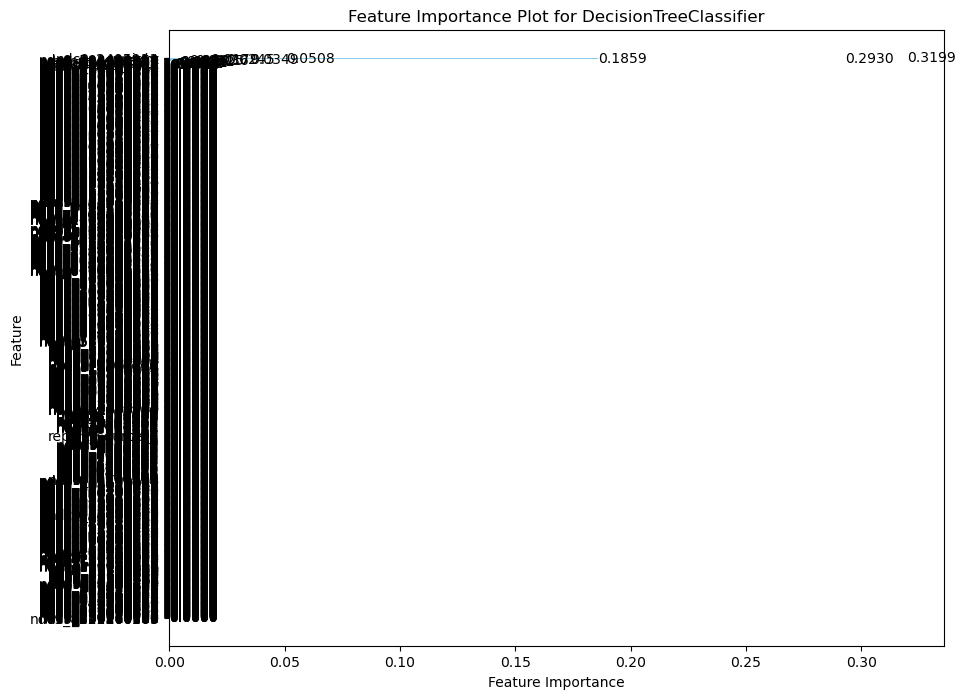

In [120]:
# Feature Importance Scores
# Extract feature importances
importances = tree1.feature_importances_
features = X_train_under.columns

# Create a DataFrame for better plotting
importance_df = pd.DataFrame({"Feature": features, "Importance": importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
bars = plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance Plot for DecisionTreeClassifier")
plt.gca().invert_yaxis()  # To display the most important feature at the top
# Add labels to the bars
for bar in bars:
    plt.text(
        bar.get_width(),
        bar.get_y() + bar.get_height() / 2,
        f"{bar.get_width():.4f}",
        va="center",
    )

plt.show()

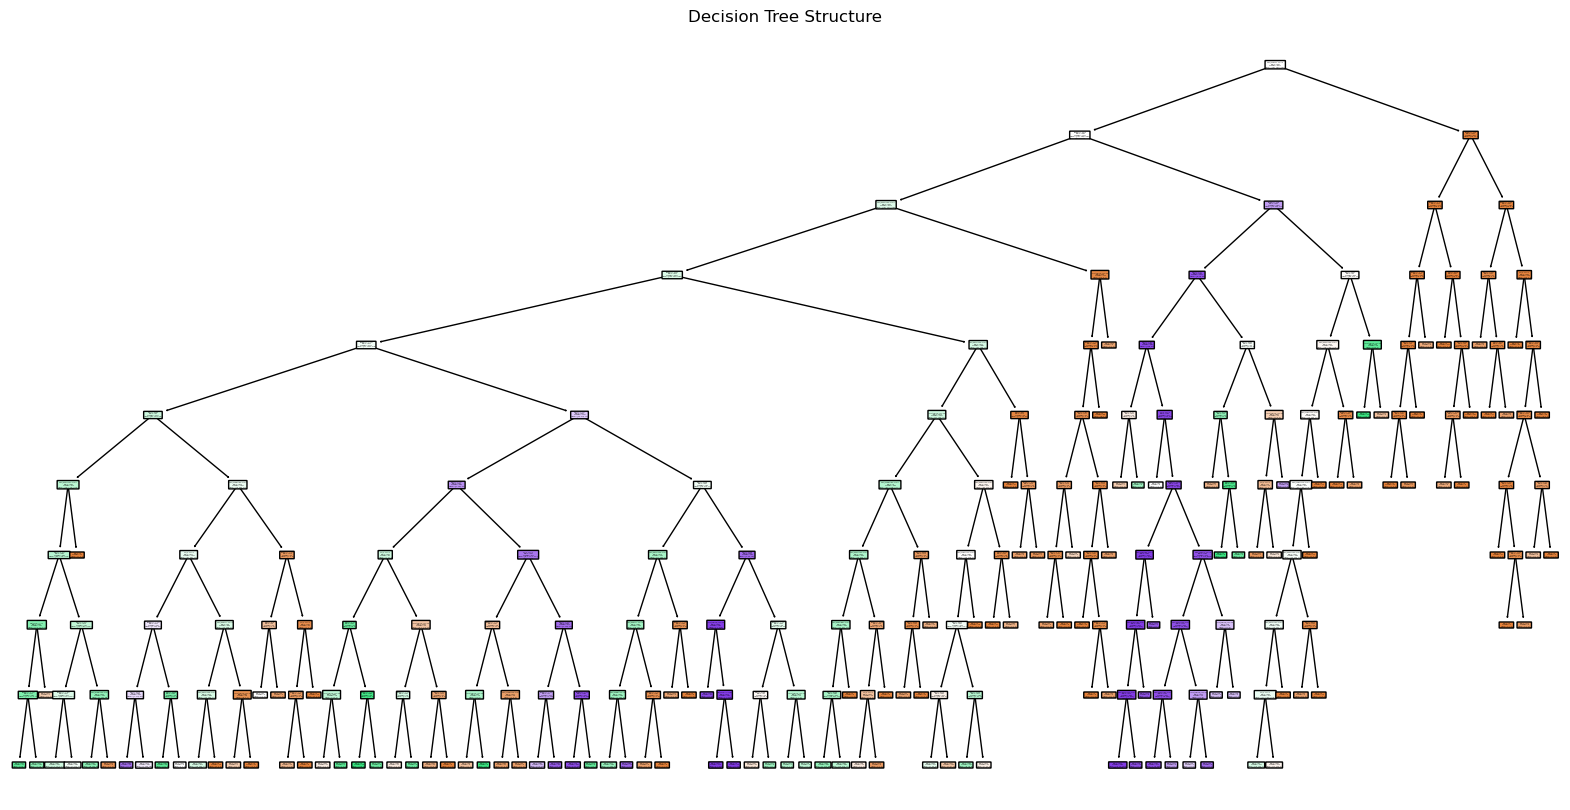

In [121]:
from sklearn.tree import plot_tree

# Plot the tree structure
plt.figure(figsize=(20, 10))
plot_tree(
    tree1,
    filled=True,
    feature_names=X_train_under.columns,
    class_names=["NonSerious", "Serious", "Death"],
    rounded=True,
)
plt.title("Decision Tree Structure")
plt.show()

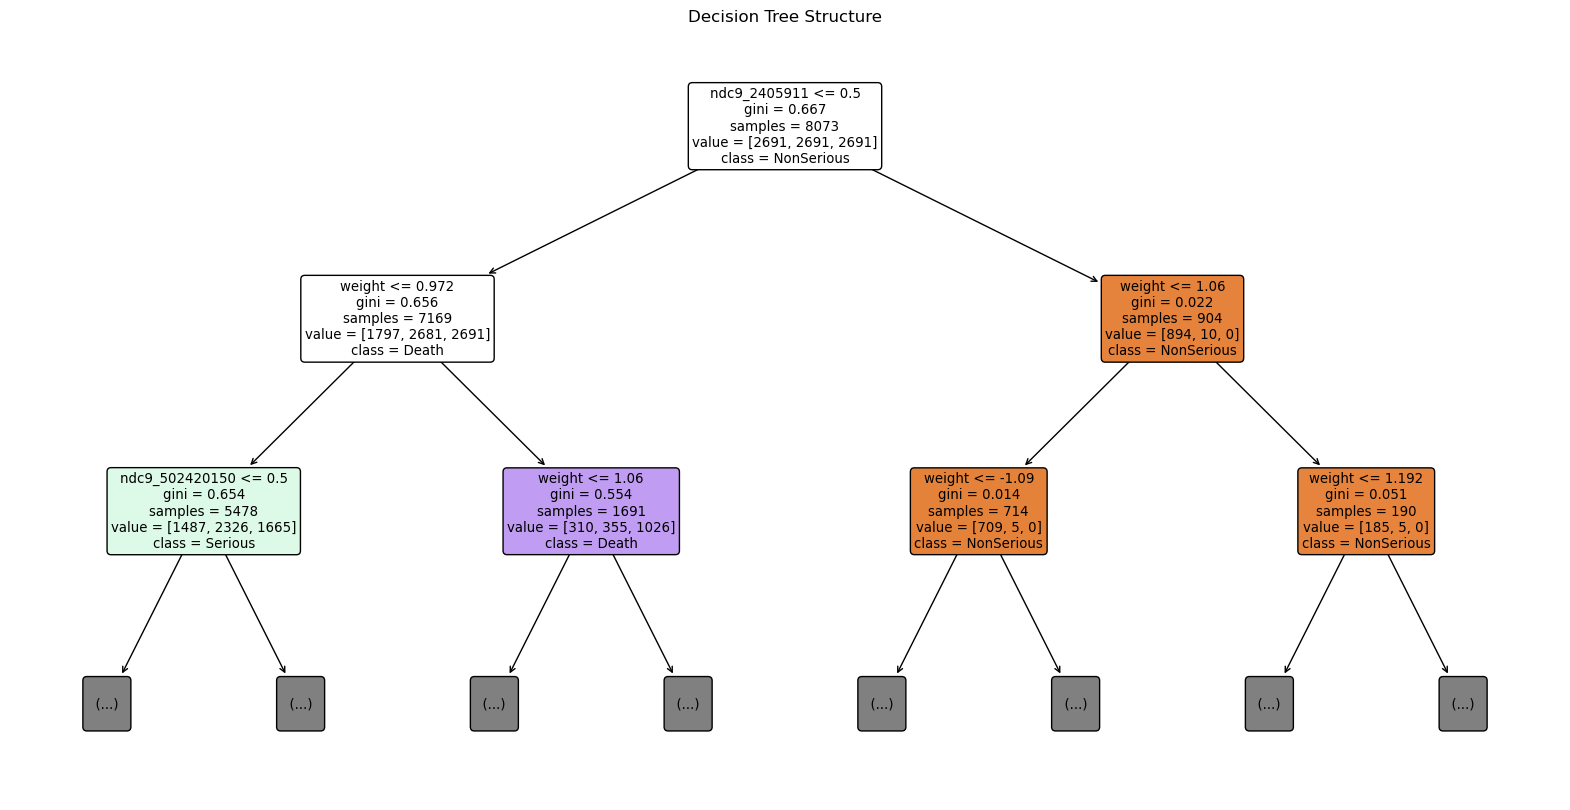

<Figure size 640x480 with 0 Axes>

In [122]:
# Plot max_depth = 2
from sklearn.tree import plot_tree

folder_path = "ModelOutput"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

img_path = os.path.join(folder_path, "tree1_maxdepth2.png")

# Plot the tree structure
plt.figure(figsize=(20, 10))
plot_tree(
    tree1,
    filled=True,
    max_depth=2,
    feature_names=X_train_under.columns,
    class_names=["NonSerious", "Serious", "Death"],
    rounded=True,
)
plt.title("Decision Tree Structure")
plt.show()
plt.savefig(img_path)

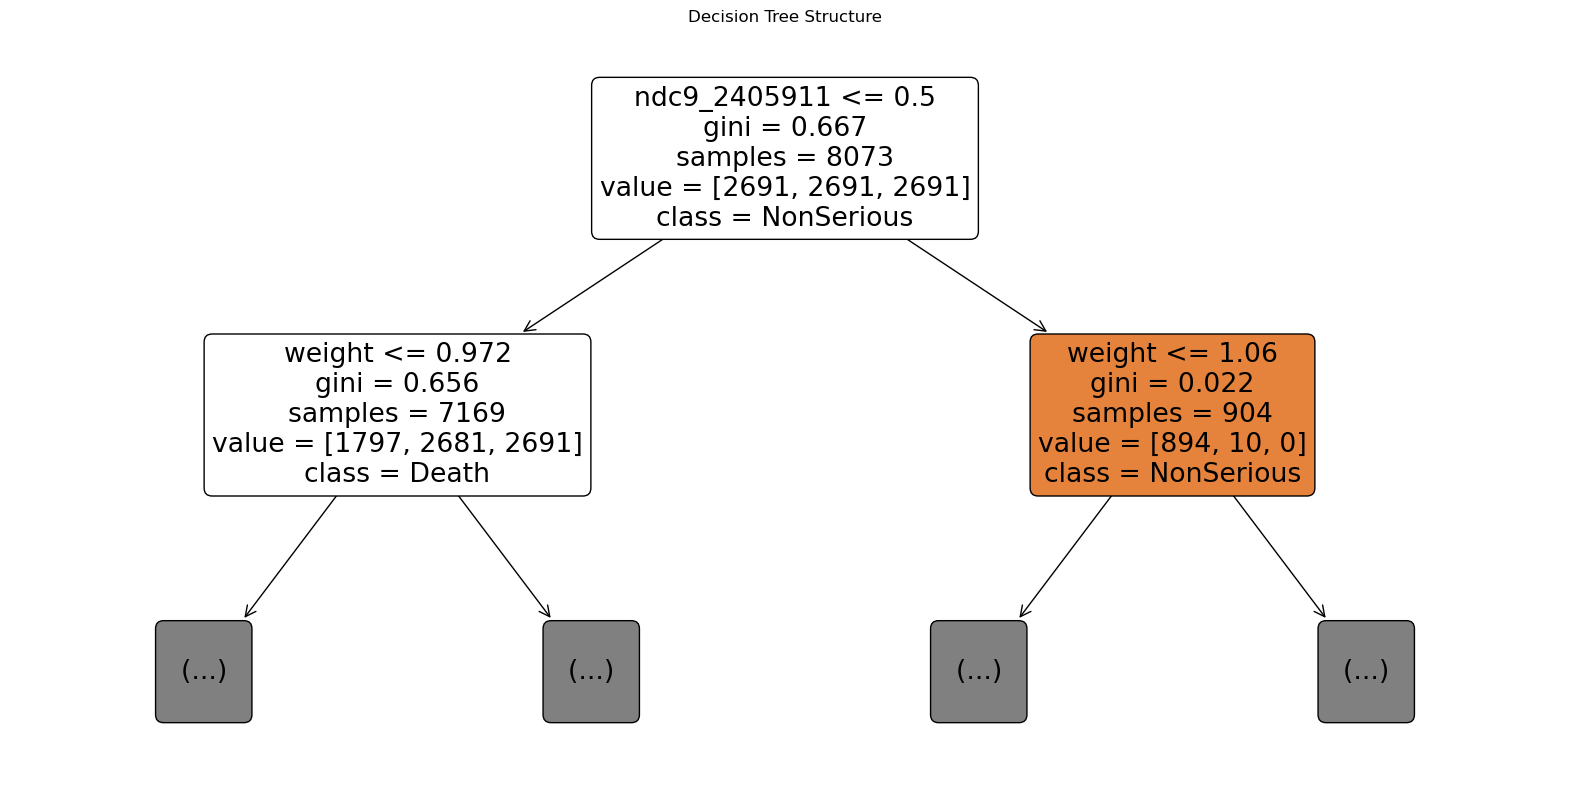

<Figure size 640x480 with 0 Axes>

In [123]:
# Plot max_depth = 1
from sklearn.tree import plot_tree

folder_path = "../ImageLibrary/DecisionTree"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

img_path = os.path.join(folder_path, "tree1_maxdepth1.png")

# Plot the tree structure
plt.figure(figsize=(20, 10))
plot_tree(
    tree1,
    filled=True,
    max_depth=1,
    feature_names=X_train_under.columns,
    class_names=["NonSerious", "Serious", "Death"],
    rounded=True,
)
plt.title("Decision Tree Structure")
plt.show()
plt.savefig(img_path)

## Ensembles

### Random Forest Classifier w/ 5-k CV

#### Grid Search

In [125]:
start_time = time.time()


param_grid = {
    "n_estimators": [100, 125, 150, 175, 200]  # Example range for number of estimators
}

# Initialize the Random Forest Classifier
random_forest = RandomForestClassifier(random_state=1)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=random_forest,
    param_grid=param_grid,
    cv=5,  # Number of cross-validation folds
    scoring="accuracy",  # Use accuracy as the scoring metric
    n_jobs=-1,  # Use all available cores
    verbose=2,
)  # Print progress messages

# Fit GridSearchCV to the data
grid_search.fit(X_train_under, y_train_under.values.ravel())

# Get the best model from the grid search
rf = grid_search.best_estimator_

rf.fit(X_train_under, y_train_under)

# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Example: Printing the best model parameters
print("Best Random Forest Model:")
print(rf)

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters: {'n_estimators': 125}
Best Score: 0.8233611472372162
Best Random Forest Model:
RandomForestClassifier(n_estimators=125, random_state=1)
111.15608072280884


#### Fit Model on Testing Data, Model Performance Metrics

In [126]:
model_name = "rf"

# Run model on test data, generate confusion matrix, save y_pred
rf_metrics_df, rf_img_path, rf_y_pred = evaluate_model(
    rf, X_test_encoded, y_test, labels=[0, 1, 2], model_name=model_name
)

rf_metrics_df.head()

,model,class,accuracy,precision,recall,f1_score,specificity
0,rf,0,0.807,0.416,0.909,0.571,0.996
1,rf,1,0.807,0.922,0.799,0.857,0.642
2,rf,2,0.807,0.692,0.811,0.747,0.930


In [70]:
X_test.iloc[4:10, :]

,sex,report_source,ndc9,weight,age,unit_price
51207,1,1,662150501,80,60,0.48535
46366,2,1,2405911,86,62,0.48535
34475,2,3,690760105,54,36,0.48491
79608,2,1,592120562,97,44,0.48535
35561,1,1,423880023,72,62,0.48535
77614,2,3,45601201,61,72,0.48535


In [71]:
X_test_encoded.iloc[4:10, :]

,weight,age,unit_price,sex_2,report_source_1,report_source_2,report_source_3,ndc9_200152,ndc9_200213,ndc9_202980,...,ndc9_7359409301,ndc9_7467605902,ndc9_7632901912,ndc9_7632903318,ndc9_7632908261,ndc9_7948100090,ndc9_8076200021,ndc9_8215400449,ndc9_8224301001,ndc9_8322200200
4,0.292309,0.238082,-0.101208,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.555550,0.337560,-0.101208,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,-0.848398,-0.955657,-0.101208,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.038157,-0.557744,-0.101208,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,-0.058678,0.337560,-0.101208,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,-0.541285,0.834952,-0.101208,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
rf_y_preds = rf.predict(X_test_encoded.iloc[4:10, :])
rf_y_preds

array([1, 0, 1, 2, 0, 2], dtype=int64)

In [73]:
y_test.iloc[4:10, :]

,serious_outcome
51207,1
46366,0
34475,1
79608,2
35561,0
77614,2


#### Get Probabilities for AUC

In [127]:
rf_y_pred_proba = rf.predict_proba(X_test_encoded)  # This should be a 2D array

#### View Classification Matrix

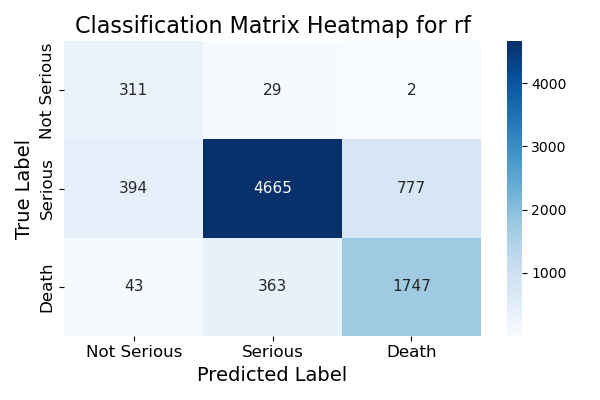

In [128]:
display(Image(filename=rf_img_path))

#### Other Metrics - Top 5 Feature Importance

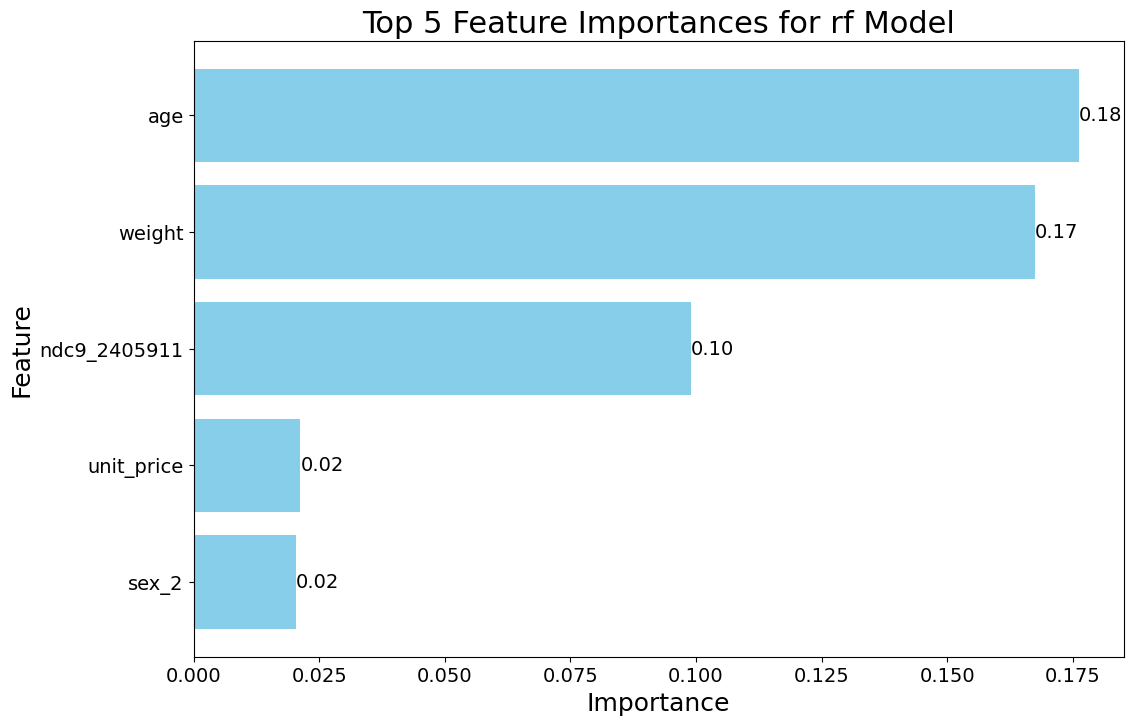

In [55]:
%matplotlib inline

# Get the feature importances
importances = rf.feature_importances_

# Get the feature names
feature_names = X_train_encoded.columns

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Select the top 5 features
top_n = 5
top_indices = indices[:top_n]
top_importances = importances[top_indices]
top_feature_names = feature_names[top_indices]

# Plot the top 5 feature importances
plt.figure(figsize=(12, 8))  # Increased figure size for better readability
bars = plt.barh(top_feature_names, top_importances, color="skyblue", align="center")

# Add data labels
for bar in bars:
    plt.text(
        bar.get_width(),
        bar.get_y() + bar.get_height() / 2,
        f"{bar.get_width():.2f}",
        va="center",
        ha="left",
        color="black",
        fontsize=14,
    )

# Customize plot appearance
plt.title("Top 5 Feature Importances for rf Model", fontsize=22)
plt.xlabel("Importance", fontsize=18)
plt.ylabel("Feature", fontsize=18)
plt.gca().invert_yaxis()  # To display the highest importance at the top

# Set tick labels font size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Show the plot
plt.show()

#### Top 10 Feature Importance

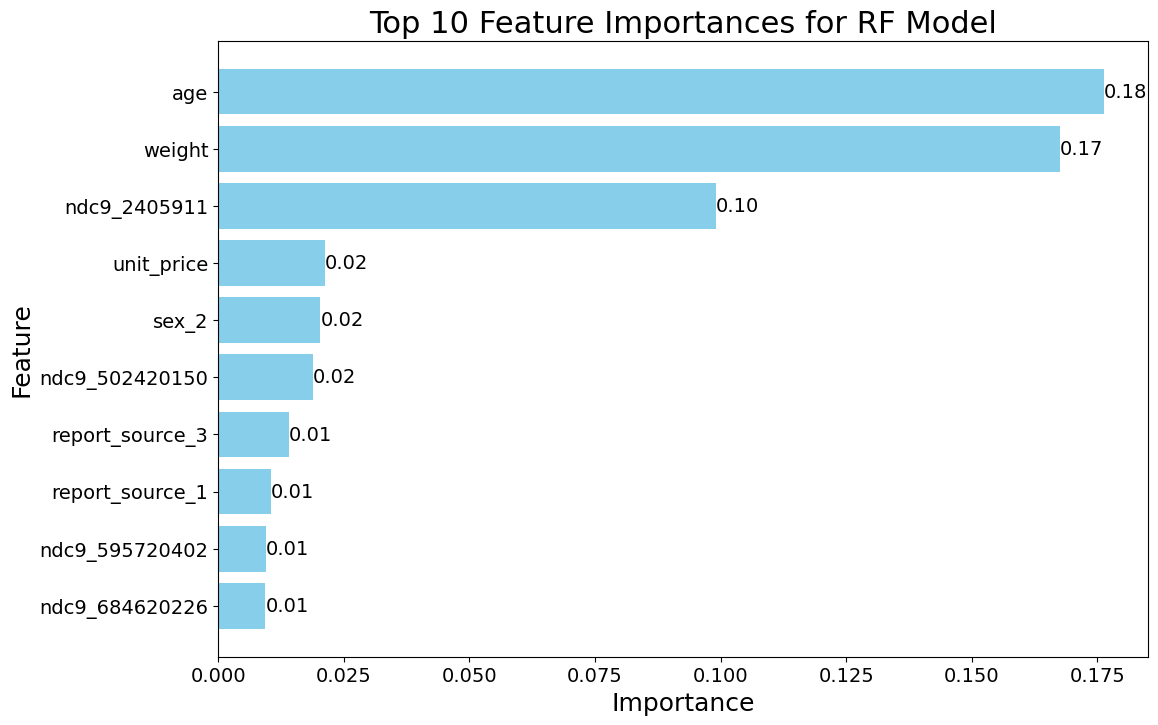

In [57]:
%matplotlib inline

# Get the feature importances
importances = rf.feature_importances_

# Get the feature names
feature_names = X_train_encoded.columns

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Select the top 5 features
top_n = 10
top_indices = indices[:top_n]
top_importances = importances[top_indices]
top_feature_names = feature_names[top_indices]

# Plot the top 5 feature importances
plt.figure(figsize=(12, 8))  # Increased figure size for better readability
bars = plt.barh(top_feature_names, top_importances, color="skyblue", align="center")

# Add data labels
for bar in bars:
    plt.text(
        bar.get_width(),
        bar.get_y() + bar.get_height() / 2,
        f"{bar.get_width():.2f}",
        va="center",
        ha="left",
        color="black",
        fontsize=14,
    )

# Customize plot appearance
plt.title("Top 10 Feature Importances for RF Model", fontsize=22)
plt.xlabel("Importance", fontsize=18)
plt.ylabel("Feature", fontsize=18)
plt.gca().invert_yaxis()  # To display the highest importance at the top

# Set tick labels font size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Show the plot
plt.show()

#### Save Pretrained Model using joblib

In [ ]:
# Save the model to the new directory
joblib.dump(rf, "Pretrained_Model_and_Apps/rf.joblib")

### Gradient Boosted Tree w/ 10-k CV

#### Grid Search

In [ ]:
start_time = time.time()

# Define a grid of hyperparameters to search for in the Gradient Boosting Classifier
param_grid = {
    "max_depth": [5, 6, 7, 8, 9, 10],
    "learning_rate": [0.0001, 0.001, 0.01, 0.1, 1],
    "n_estimators": [50, 75, 100, 125, 150],
}
# Create a GridSearchCV object using GradientBoostingClassifier and the defined parameter grid
tree_search = GridSearchCV(
    GradientBoostingClassifier(random_state=1), param_grid, cv=10, n_jobs=-1
)
# Fit the GridSearchCV to the balanced training data to find the best hyperparameters
tree_search.fit(X_train_under, y_train_under.values.ravel())
# Get the best hyperparameters found by the GridSearch
tree_search.best_params_

grboost = tree_search.best_estimator_


# Print the best parameters and the best score
print("Best Parameters:", tree_search.best_params_)
print("Best Score:", tree_search.best_score_)

# Example: Printing the best model parameters
print("Best Gradient Boosted Tree:")
print(grboost)

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

In [280]:
start_time = time.time()

# Define a grid of hyperparameters to search for in the Gradient Boosting Classifier
param_grid = {
    "max_depth": [10],
    "learning_rate": [0.1],
    "n_estimators": [150],
}
# Create a GridSearchCV object using GradientBoostingClassifier and the defined parameter grid
tree_search = GridSearchCV(
    GradientBoostingClassifier(random_state=1), param_grid, cv=10, n_jobs=-1
)
# Fit the GridSearchCV to the balanced training data to find the best hyperparameters
tree_search.fit(X_train_under, y_train_under.values.ravel())
# Get the best hyperparameters found by the GridSearch
tree_search.best_params_

grboost = tree_search.best_estimator_

# Print the best parameters and the best score
print("Best Parameters:", tree_search.best_params_)
print("Best Score:", tree_search.best_score_)

# Example: Printing the best model parameters
print("Best Gradient Boosted Tree:")
print(grboost)

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 150}
Best Score: 0.8141992405560259
Best Gradient Boosted Tree:
GradientBoostingClassifier(max_depth=10, n_estimators=150, random_state=1)
469.8639340400696


#### Fit Model on Testing Data, Model Performance Metrics

In [281]:
model_name = "grboost"

# Run model on test data, generate confusion matrix, save y_pred
grboost_metrics_df, grboost_img_path, grboost_y_pred = evaluate_model(
    grboost, X_test_encoded, y_test, labels=[0, 1, 2], model_name=model_name
)

grboost_metrics_df.head()

,model,class,accuracy,precision,recall,f1_score,specificity
0,grboost,0,0.834,0.448,0.804,0.575,0.991
1,grboost,1,0.834,0.917,0.845,0.880,0.694
2,grboost,2,0.834,0.744,0.807,0.774,0.931


#### Get probabilities for AUC

In [282]:
grboost_y_pred_proba = grboost.predict_proba(
    X_test_encoded
)  # This should be a 2D array

#### View Classification Matrix

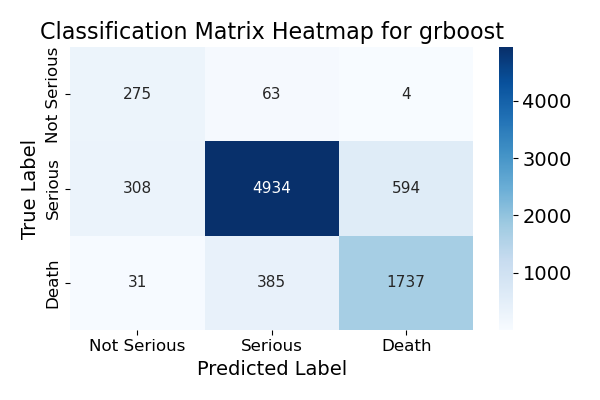

In [283]:
display(Image(filename=grboost_img_path))

#### Other Metrics

In [284]:
# Get feature importance scores
importances = grboost.feature_importances_
feature_importance_pairs = list(zip(X_train_under.columns, importances))

# Sort in descending order
sorted_feature_importance_pairs = sorted(
    feature_importance_pairs, key=lambda x: x[1], reverse=True
)

# Print scores
print("Feature Importance Scores")
for feature, importance in sorted_feature_importance_pairs:
    print(f"{feature}: {importance:.4f}")

Feature Importance Scores
weight: 0.2352
age: 0.1965
ndc9_2405911: 0.1576
ndc9_502420150: 0.0293
sex_2: 0.0242
ndc9_684620226: 0.0201
report_source_3: 0.0150
ndc9_423880023: 0.0147
ndc9_595720402: 0.0137
ndc9_593530400: 0.0110
ndc9_6900187: 0.0102
report_source_1: 0.0092
unit_price: 0.0083
ndc9_119940011: 0.0077
ndc9_673860130: 0.0058
report_source_2: 0.0058
ndc9_720600110: 0.0053
ndc9_622070922: 0.0050
ndc9_824480050: 0.0044
ndc9_722870310: 0.0041
ndc9_2405908: 0.0040
ndc9_17300909: 0.0038
ndc9_595720501: 0.0031
ndc9_5846800040: 0.0027
ndc9_690970897: 0.0025
ndc9_724260118: 0.0025
ndc9_7800846: 0.0024
ndc9_6905317: 0.0023
ndc9_492300530: 0.0022
ndc9_609230227: 0.0022
ndc9_256820010: 0.0021
ndc9_829430100: 0.0021
ndc9_1302626: 0.0021
ndc9_555130190: 0.0021
ndc9_203002: 0.0020
ndc9_657570401: 0.0020
ndc9_688170134: 0.0020
ndc9_7801000: 0.0020
ndc9_6050506282: 0.0019
ndc9_4600872: 0.0018
ndc9_502420917: 0.0017
ndc9_2305858: 0.0017
ndc9_461220281: 0.0017
ndc9_657570300: 0.0017
ndc9_690013

## Non-parametric

### K-Nearest Neighbors Classifier

#### Grid Search

In [184]:
# Define the parameter grid for GridSearchCV
param_grid = {
    "n_neighbors": [
        1,
        3,
        5,
        7,
        9,
        11,
        13,
        15,
        17,
        19,
        21,
    ]  # Example range for number of neighbors
}

# Initialize the K-Nearest Neighbors Classifier
knn = KNeighborsClassifier()

# Initialize GridSearchCV
grid_search_knn = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,  # Number of cross-validation folds
    scoring="accuracy",  # Use accuracy as the scoring metric
    n_jobs=-1,  # Use all available cores
    verbose=2,
)  # Print progress messages

# Fit GridSearchCV to the data
grid_search_knn.fit(X_train_under, y_train_under.values.ravel())

# Get the best model from the grid search
knn = grid_search_knn.best_estimator_

# Print the best parameters and the best score
print("Best Parameters for KNN:", grid_search_knn.best_params_)
print("Best Score for KNN:", grid_search_knn.best_score_)

# Example: Printing the best model parameters
print("Best KNN Model:")
print(knn)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
Best Parameters for KNN: {'n_neighbors': 1}
Best Score for KNN: 0.7589476753330955
Best KNN Model:
KNeighborsClassifier(n_neighbors=1)


#### Fit Model on Testing Data, Model Performance Metrics

In [185]:
model_name = "knn"

# Run model on test data, generate confusion matrix, save y_pred
knn_metrics_df, knn_img_path, knn_y_pred = evaluate_model(
    knn, X_test_encoded, y_test, labels=[0, 1, 2], model_name=model_name
)

knn_metrics_df.head()

,model,class,accuracy,precision,recall,f1_score,specificity
0,knn,0,0.687,0.247,0.918,0.389,0.996
1,knn,1,0.687,0.891,0.650,0.751,0.498
2,knn,2,0.687,0.577,0.752,0.653,0.903


#### Get Probabilities for AUC

In [186]:
knn_y_pred_proba = knn.predict_proba(X_test_encoded)  # This should be a 2D array

#### View Classification Matrix

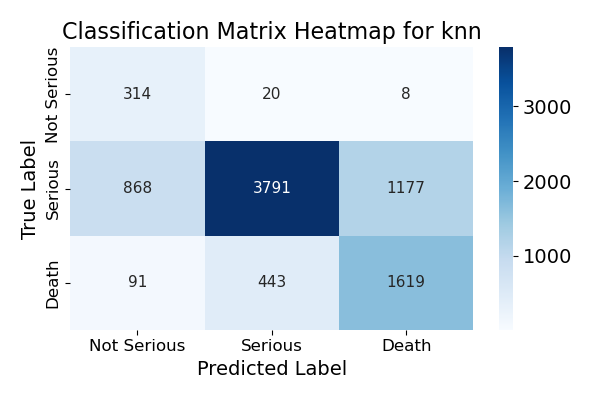

In [187]:
display(Image(filename=knn_img_path))

#### Other Metrics

### Baseline

In [188]:
from sklearn.dummy import DummyClassifier

baseline_model = DummyClassifier(strategy="most_frequent")
baseline_model.fit(X_test_encoded, y_test)
baseline_metrics_df, baseline_img_path, _ = evaluate_model(
    baseline_model, X_test_encoded, y_test, labels=[0, 1, 2], model_name="Baseline"
)
baseline_metrics_df

,model,class,accuracy,precision,recall,f1_score,specificity
0,Baseline,0,0.701,0.000,0.0,0.000,0.959
1,Baseline,1,0.701,0.701,1.0,0.824,NaN
2,Baseline,2,0.701,0.000,0.0,0.000,0.742


# Performance Metrics Table

In [289]:
model_metrics = display_model_metrics_table(
    [
        baseline_metrics_df,
        log_l1_metrics_df,
        log_l2_metrics_df,
        elastic_net_metrics_df,
        tree1_metrics_df,
        rf_metrics_df,
        knn_metrics_df,
        grboost_metrics_df,
    ]
)

+-------------+-------+----------+-----------+--------+----------+-------------+
|    model    | class | accuracy | precision | recall | f1_score | specificity |
+-------------+-------+----------+-----------+--------+----------+-------------+
|  Baseline   |   0   |  0.701   |    0.0    |  0.0   |   0.0    |    0.959    |
|  Baseline   |   1   |  0.701   |   0.701   |  1.0   |  0.824   |     nan     |
|  Baseline   |   2   |  0.701   |    0.0    |  0.0   |   0.0    |    0.742    |
|   log_l1    |   0   |  0.664   |   0.397   | 0.801  |  0.531   |    0.991    |
|   log_l1    |   1   |  0.664   |   0.829   | 0.671  |  0.742   |    0.468    |
|   log_l1    |   2   |  0.664   |   0.459   | 0.622  |  0.528   |    0.85     |
|   log_l2    |   0   |  0.661   |   0.37    | 0.822  |   0.51   |    0.992    |
|   log_l2    |   1   |  0.661   |   0.845   | 0.648  |  0.734   |    0.467    |
|   log_l2    |   2   |  0.661   |   0.465   | 0.668  |  0.548   |    0.863    |
| elastic_net |   0   |  0.6

### Show Class Outcomes more Cleanly for Paper

Saves as csv, that can copy paste into the Excel file within the same folder. This makes it easy to paste the values into the paper

In [290]:
def format_as_percentage(df):
    # Format metrics as percentage with one decimal point
    #   df['accuracy'] = df['accuracy'].apply(lambda x: f"{x * 100:.1f}%")
    df["precision"] = df["precision"].apply(lambda x: f"{x * 100:.1f}%")
    df["recall"] = df["recall"].apply(lambda x: f"{x * 100:.1f}%")
    df["specificity"] = df["specificity"].apply(lambda x: f"{x * 100:.1f}%")
    df["f1_score"] = df["f1_score"].apply(lambda x: f"{x * 100:.1f}%")
    return df


model_metrics = format_as_percentage(model_metrics)


def aggregate_metrics(df):
    # Group by 'model'
    grouped = (
        df.groupby("model")
        .agg(
            {
                "accuracy": "mean",  # Average accuracy
                "precision": lambda x: x.tolist(),  # List of precision values
                "recall": lambda x: x.tolist(),  # List of recall values
                "specificity": lambda x: x.tolist(),  # List of specificity values
                "f1_score": lambda x: x.tolist(),  # List of F1 scores
            }
        )
        .reset_index()
    )

    return grouped


# Apply aggregation function
aggregated_df = aggregate_metrics(model_metrics)

# Rename columns
aggregated_df = aggregated_df.rename(
    columns={
        #  'model': 'Model',
        "accuracy": "Accuracy",
        "precision": "Precision (class 0,1,2)",
        "recall": "Recall (class 0,1,2)",
        "f1_score": "F-score (class 0,1,2)",
        "specificity": "Specificity (class 0,1,2)",
    }
)


# Rename values in 'model' column
aggregated_df["model"] = aggregated_df["model"].replace(
    {
        "elastic_net": "Elastic Net",
        "knn": "KNN",
        "tree1": "Decision Tree",
        "log_l1": "Lasso Regression",
        "log_l2": "Ridge Regression",
        "rf": "Random Forest",
        "grboost": "Gradient Boosted Decision Tree",
    }
)

aggregated_df["Accuracy"] = aggregated_df["Accuracy"].apply(lambda x: f"{x * 100:.1f}%")

# Display the resulting DataFrame
print(aggregated_df)

                            model Accuracy Precision (class 0,1,2)  \
0                        Baseline    70.1%     [0.0%, 70.1%, 0.0%]   
1                     Elastic Net    65.7%   [34.7%, 84.7%, 46.9%]   
2  Gradient Boosted Decision Tree    83.4%   [44.8%, 91.7%, 74.4%]   
3                             KNN    68.7%   [24.7%, 89.1%, 57.7%]   
4                Lasso Regression    66.4%   [39.7%, 82.9%, 45.9%]   
5                Ridge Regression    66.1%   [37.0%, 84.5%, 46.5%]   
6                   Random Forest    80.7%   [41.6%, 92.2%, 69.2%]   
7                   Decision Tree    74.4%   [24.8%, 85.6%, 67.2%]   

    Recall (class 0,1,2) Specificity (class 0,1,2)  F-score (class 0,1,2)  
0   [0.0%, 100.0%, 0.0%]      [95.9%, nan%, 74.2%]    [0.0%, 82.4%, 0.0%]  
1  [83.6%, 64.1%, 67.4%]     [99.3%, 46.4%, 86.6%]  [49.0%, 72.9%, 55.3%]  
2  [80.4%, 84.5%, 80.7%]     [99.1%, 69.4%, 93.1%]  [57.5%, 88.0%, 77.4%]  
3  [91.8%, 65.0%, 75.2%]     [99.6%, 49.8%, 90.3%]  [38.9%, 75.1%

In [ ]:
# Save it as a CSV
folder_path = "../DataLibrary/EvaluationMetrics"
os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, "aggregated_metrics_withpricesImputed.csv")
aggregated_df.to_csv(file_path, index=False)

### AUC Curves

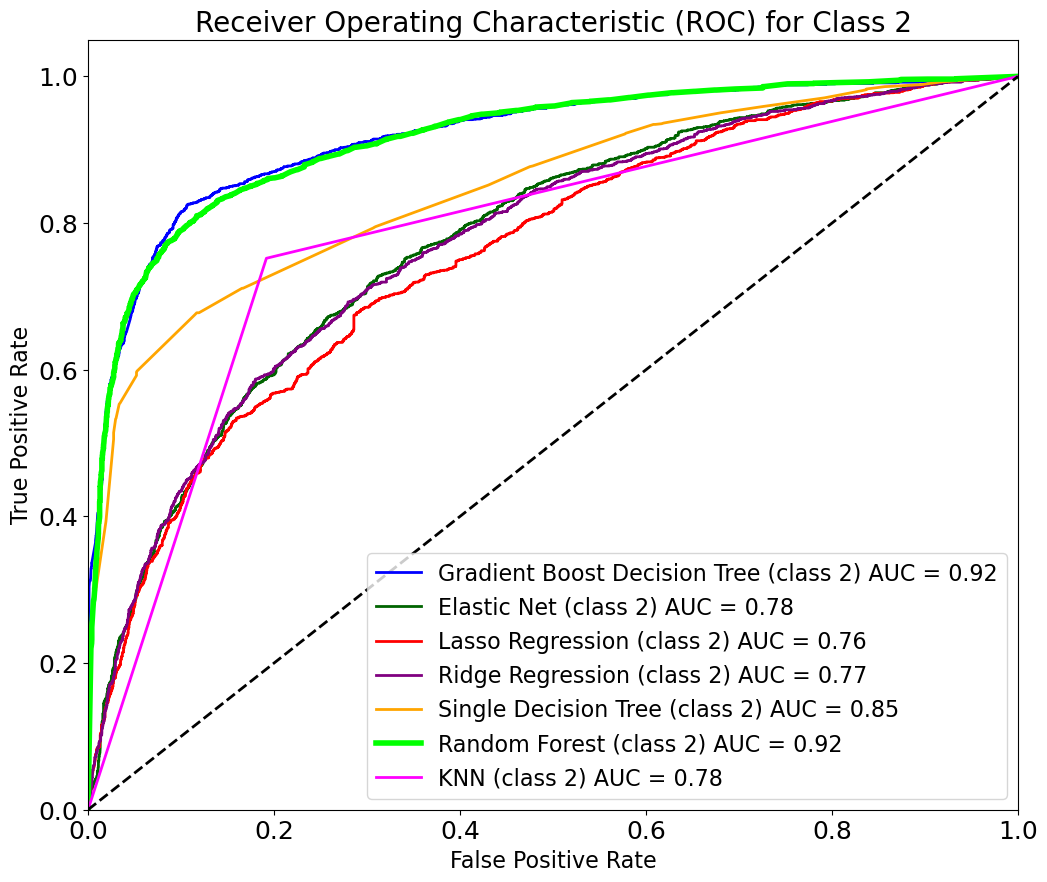

In [285]:
# Enable inline plotting in Jupyter Notebook
%matplotlib inline

# List of model names
model_names = [
    "Gradient Boost Decision Tree",
    "Elastic Net",
    "Lasso Regression",
    "Ridge Regression",
    "Single Decision Tree",
    "Random Forest",
    "KNN",
]

# List of true labels and predicted probabilities
y_tests = [
    y_test,
    y_test,
    y_test,
    y_test,
    y_test,
    y_test,
    y_test,
]  # True labels for each model
y_pred_probs = [
    grboost_y_pred_proba,
    elastic_net_y_pred_proba,
    log_l1_y_pred_proba,
    log_l2_y_pred_proba,
    tree1_y_pred_proba,
    rf_y_pred_proba,
    knn_y_pred_proba,
]  # Predicted probabilities for each model

# Colors for each model
colors = {
    "Gradient Boost Decision Tree": "blue",
    "Elastic Net": "darkgreen",
    "Lasso Regression": "red",
    "Ridge Regression": "purple",
    "Single Decision Tree": "orange",
    "Random Forest": "lime",  # Distinct color for Random Forest
    "KNN": "magenta",
}

# Number of classes
n_classes = 3

# Binarize the output labels for each class
y_tests_bin = [label_binarize(y, classes=range(n_classes)) for y in y_tests]

plt.figure(figsize=(12, 10))

# Class to focus on
class_index = 2

for model_name, y_test_bin, y_pred_prob in zip(model_names, y_tests_bin, y_pred_probs):
    # Compute ROC curve and ROC area for the specific class
    fpr, tpr, _ = roc_curve(y_test_bin[:, class_index], y_pred_prob[:, class_index])
    roc_auc = auc(fpr, tpr)

    # Set line width and color based on model
    if model_name == "Random Forest":
        lw = 4  # Thicker line for Random Forest
        color = colors.get(model_name, "black")  # Color for Random Forest
    else:
        lw = 2  # Default line width
        color = colors.get(model_name, "black")  # Default color for other models

    # Plot ROC curve for the specific class
    plt.plot(
        fpr,
        tpr,
        lw=lw,
        color=color,
        label=f"{model_name} (class {class_index}) AUC = {roc_auc:.2f}",
    )

# Plot random guess line
plt.plot([0, 1], [0, 1], "k--", lw=2)

# Set axis labels and title with font sizes
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)
plt.title("Receiver Operating Characteristic (ROC) for Class 2", fontsize=20)

# Adjust the size of the axis ticks and legend
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc="lower right", fontsize=16)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

folder_path = "../ImageLibrary"
img_path = os.path.join(folder_path, "ROCPlot.png")
plt.savefig(img_path)

plt.show()

# Top Model Performance on Validation Data

In [287]:
model_name = "rf"

# Run model on test data, generate confusion matrix, save y_pred
rf_metrics_df_val, rf_img_path_val, rf_y_pred_val = evaluate_model(
    rf, X_val_encoded, y_val, labels=[0, 1, 2], model_name=model_name
)

rf_metrics_df_val.head()

,model,class,accuracy,precision,recall,f1_score,specificity
0,rf,0,0.811,0.420,0.915,0.576,0.996
1,rf,1,0.811,0.923,0.806,0.860,0.656
2,rf,2,0.811,0.702,0.808,0.751,0.928


# Top Model Feature Relationships Inspection

In [25]:
master_query_df["serious_labels"] = master_query_df["serious_outcome"].replace(
    {0: "NonSerious", 1: "Serious", 2: "Death"}
)

### Top 4 Drugs Descriptives: Age, Weight, Price, Sex, Report Source, Outcome

In [274]:
input_ndc_list = [
    2405911,  # Dupixent
    502420150,  # Ocrevus
    595720402,  # Revlimid
    684620226,
]  # Ezetimibe
drug_names = ["Dupixent", "Ocrevus", "Revlimid", "Ezetimibe"]
nums = ["age", "weight", "unit_price"]
cats = ["sex", "report_source", "serious_outcome"]

num_desc, counts_df = top_drug_comparison(input_ndc_list)

In [277]:
num_desc

Mean                           StdDev             \
                 age     weight unit_price        age     weight   
2405911    45.692042  78.497578    0.48535  21.880657  29.414099   
502420150  46.035714  74.180672    0.48535  13.076004  17.354900   
595720402  74.067055  77.798834    0.48535  10.658914  23.402599   
684620226  67.532847  77.624088    0.10207  10.046085  17.431633   

                         DrugNames  
             unit_price             
2405911    5.941750e-15   Dupixent  
502420150  3.667591e-15    Ocrevus  
595720402  7.782915e-16   Revlimid  
684620226  4.031923e-16  Ezetimibe

In [278]:
counts_df

,DrugName,level_0,level_1,sex,report_source,serious_outcome
0,Dupixent,2405911,1,0.40,0.97,0.20
1,Dupixent,2405911,2,0.60,0.01,0.01
2,Dupixent,2405911,3,NaN,0.03,NaN
3,Dupixent,2405911,0,NaN,NaN,0.79
4,Ocrevus,502420150,1,0.24,0.86,0.54
5,Ocrevus,502420150,2,0.76,0.02,0.02
6,Ocrevus,502420150,3,NaN,0.12,NaN
7,Ocrevus,502420150,0,NaN,NaN,0.44
8,Revlimid,595720402,2,0.46,0.28,0.18
9,Revlimid,595720402,1,0.54,0.17,0.53


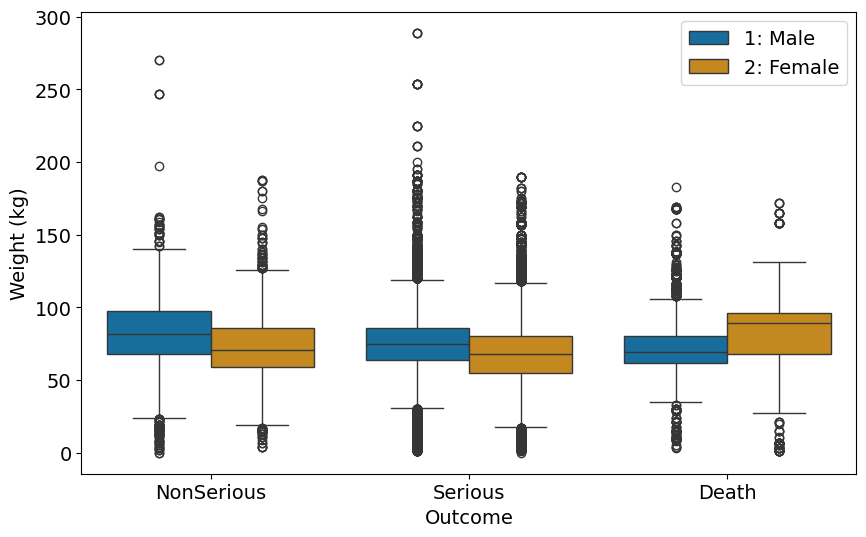

In [180]:
# Update text size
plt.rcParams.update({"font.size": 14})

# Boxplot with grouping variable "Outcome"
plt.figure(figsize=(10, 6))
sns.boxplot(
    x="serious_labels",
    y="weight",
    hue="sex",
    data=master_query_df,
    palette="colorblind",
)

# Customize the plot
plt.xlabel("Outcome")
plt.ylabel("Weight (kg)")
# plt.title('Age Distribution by Outcome and Sex')

# Customize legend labels
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["1: Male", "2: Female"]
plt.legend(handles, labels, loc="upper right")

# Show the plot
plt.show()

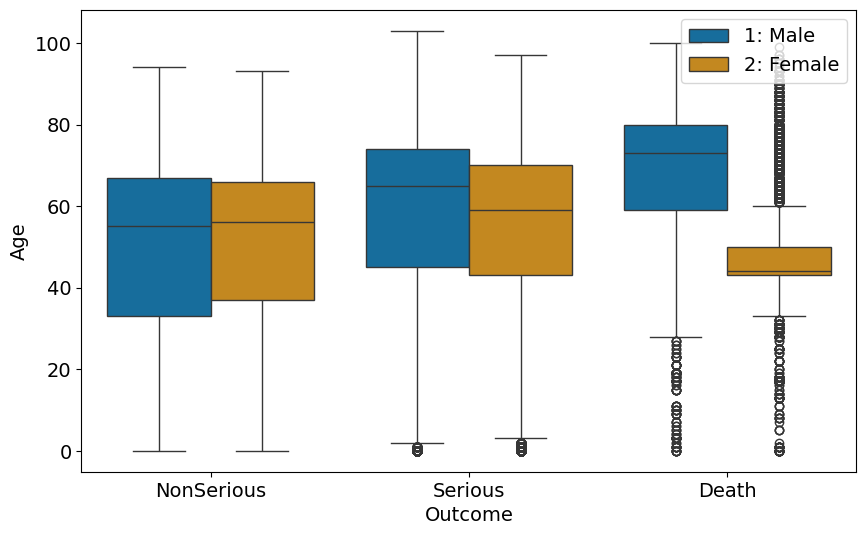

In [148]:
# Update text size
plt.rcParams.update({"font.size": 14})

# Boxplot with grouping variable "Outcome"
plt.figure(figsize=(10, 6))
sns.boxplot(
    x="serious_labels", y="age", hue="sex", data=master_query_df, palette="colorblind"
)

# Customize the plot
plt.xlabel("Outcome")
plt.ylabel("Age")
# plt.title('Age Distribution by Outcome and Sex')

# Customize legend labels
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["1: Male", "2: Female"]
plt.legend(handles, labels, loc="upper right")

# Show the plot
plt.show()

### Top Drugs by Outcome

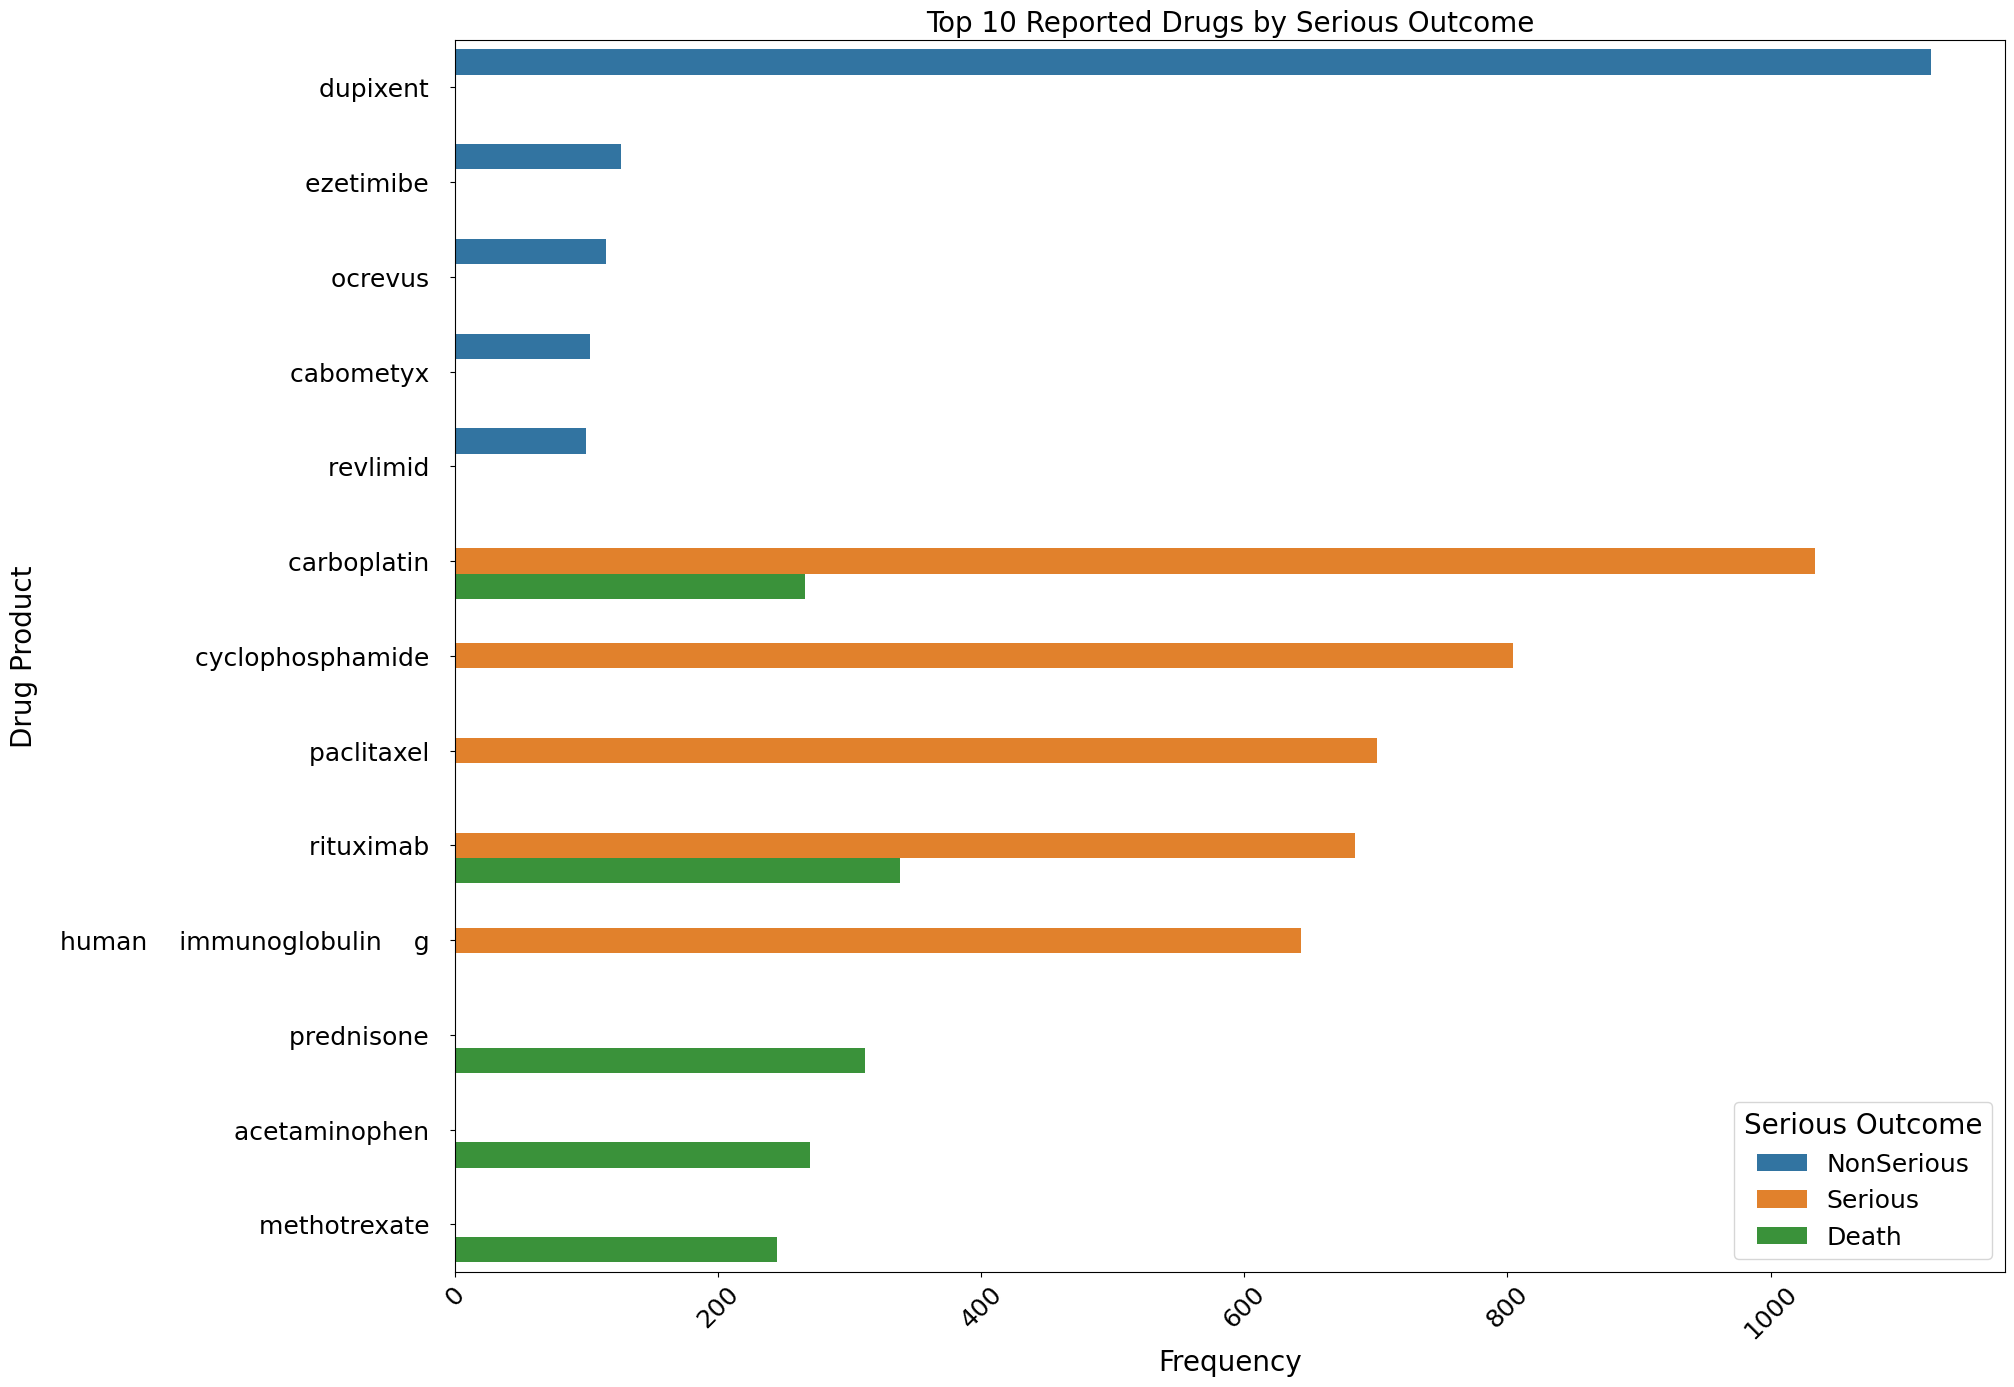

In [43]:
# Function to clean med_product column
def clean_med_product(med_product):
    # Remove brackets, quotation marks, and commas
    return re.sub(r"[,\[\]'\" ]", " ", med_product)


master_query_df["clean_med"] = master_query_df["med_product"].apply(clean_med_product)

# Group by serious_labels, clean_med, and ndc9 to get the counts
top_drugs = (
    master_query_df.groupby(["serious_labels", "clean_med", "ndc9"])
    .size()
    .reset_index(name="count")
)

# Get the top 10 drugs per serious label
top_drugs = (
    top_drugs.groupby("serious_labels")
    .apply(lambda x: x.nlargest(5, "count"))
    .reset_index(drop=True)
)

# Calculate the total counts per serious label to compute the percentage
top_drugs["total"] = top_drugs.groupby("serious_labels")["count"].transform("sum")
top_drugs["percentage"] = round((top_drugs["count"] / top_drugs["total"]) * 100, 2)

plt.figure(figsize=(20, 16))
sns.barplot(x="count", y="clean_med", hue="serious_labels", data=top_drugs, ci=None)
plt.xlabel("Frequency", fontsize=20)
plt.ylabel("Drug Product", fontsize=20)
plt.title("Top 10 Reported Drugs by Serious Outcome", fontsize=20)
plt.legend(title="Serious Outcome", title_fontsize=20, fontsize=18)
plt.xticks(rotation=45, fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [45]:
table = tabulate(
    top_drugs[["serious_labels", "clean_med", "ndc9", "count", "percentage"]],
    headers="keys",
    tablefmt="fancy",
)
print(table)

    serious_labels    clean_med                           ndc9    count    percentage
--  ----------------  ----------------------------  ----------  -------  ------------
 0  NonSerious        dupixent                         2405911     1122         71.65
 1  NonSerious        ezetimibe                      684620226      126          8.05
 2  NonSerious        ocrevus                        502420150      115          7.34
 3  NonSerious        cabometyx                      423880023      103          6.58
 4  NonSerious        revlimid                       595720402      100          6.39
 5  Serious           carboplatin                   6050506282     1034         26.75
 6  Serious           cyclophosphamide               829430100      804         20.8
 7  Serious           paclitaxel                     688170134      701         18.13
 8  Serious           rituximab                      502420051      684         17.69
 9  Serious           human    immunoglobulin    g  698

In [46]:
top_drugs[["serious_labels", "clean_med", "ndc9", "count", "percentage"]].to_excel(
    "C://Users/{user}/Downloads/top_drugs.xlsx", index=False
)

## Follow Up Statistical Tests between Features

In [57]:
stat_data = master_query_df[["age", "weight", "sex", "serious_outcome"]]

In [58]:
# Create dummy variables for the categorical variables
stat_data = pd.get_dummies(
    stat_data, columns=["sex", "serious_outcome"], drop_first=False
)

In [59]:
stat_data

,age,weight,sex_1,sex_2,serious_outcome_0,serious_outcome_1,serious_outcome_2
0,25,95,True,False,False,True,False
1,25,95,True,False,False,True,False
2,25,95,True,False,False,True,False
3,25,95,True,False,False,True,False
4,25,95,True,False,False,True,False
...,...,...,...,...,...,...,...
83302,57,74,True,False,False,True,False
83303,39,112,False,True,False,True,False
83304,39,112,False,True,False,True,False
83305,39,112,False,True,False,True,False


In [61]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA

# Perform MANOVA
manova = MANOVA.from_formula(
    "age + weight ~ sex_2 + serious_outcome_1 + serious_outcome_2", data=stat_data
)
print(manova.mv_test())

                    Multivariate linear model
                                                                  
------------------------------------------------------------------
       Intercept        Value  Num DF   Den DF    F Value   Pr > F
------------------------------------------------------------------
          Wilks' lambda 0.6040 2.0000 83302.0000 27310.6110 0.0000
         Pillai's trace 0.3960 2.0000 83302.0000 27310.6110 0.0000
 Hotelling-Lawley trace 0.6557 2.0000 83302.0000 27310.6110 0.0000
    Roy's greatest root 0.6557 2.0000 83302.0000 27310.6110 0.0000
------------------------------------------------------------------
                                                                  
------------------------------------------------------------------
           sex_2          Value  Num DF   Den DF   F Value  Pr > F
------------------------------------------------------------------
            Wilks' lambda 0.9807 2.0000 83302.0000 820.3755 0.0000
           Pilla

In [56]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# ANOVA for age
model_age = ols(
    "age ~ sex_2 + serious_outcome_1 + serious_outcome_2", data=stat_data
).fit()
anova_age = anova_lm(model_age)
print("\nANOVA for age:")
print(anova_age)

# ANOVA for weight
model_weight = ols(
    "weight ~ sex_2 + serious_outcome_1 + serious_outcome_2", data=stat_data
).fit()
anova_weight = anova_lm(model_weight)
print("\nANOVA for weight:")
print(anova_weight)


ANOVA for age:
                        df        sum_sq        mean_sq            F  \
sex_2                  1.0  6.191383e+05  619138.315478  1562.556274   
serious_outcome_1      1.0  8.786673e+04   87866.730600   221.754506   
serious_outcome_2      1.0  3.167211e+04   31672.111766    79.932796   
Residual           83303.0  3.300750e+07     396.234252          NaN   

                         PR(>F)  
sex_2              0.000000e+00  
serious_outcome_1  4.347535e-50  
serious_outcome_2  3.950460e-19  
Residual                    NaN  

ANOVA for weight:
                        df        sum_sq        mean_sq            F  \
sex_2                  1.0  1.106579e+05  110657.894227   219.234791   
serious_outcome_1      1.0  8.996499e+05  899649.932927  1782.381330   
serious_outcome_2      1.0  8.995896e+03    8995.896492    17.822619   
Residual           83303.0  4.204686e+07     504.746048          NaN   

                         PR(>F)  
sex_2              1.536034e-49  
serio

In [63]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Combine categorical variables into a single factor for comparison
stat_data["group"] = (
    stat_data["sex_2"].astype(str)
    + "_"
    + stat_data[["serious_outcome_0", "serious_outcome_1", "serious_outcome_2"]].idxmax(
        axis=1
    )
)

# Post-hoc test for age
posthoc_age = pairwise_tukeyhsd(stat_data["age"], stat_data["group"], alpha=0.05)
print("\nPost-hoc test for age:")
print(posthoc_age)

# Post-hoc test for weight
posthoc_weight = pairwise_tukeyhsd(stat_data["weight"], stat_data["group"], alpha=0.05)
print("\nPost-hoc test for weight:")
print(posthoc_weight)


Post-hoc test for age:
                  Multiple Comparison of Means - Tukey HSD, FWER=0.05                   
         group1                  group2         meandiff p-adj   lower    upper   reject
----------------------------------------------------------------------------------------
False_serious_outcome_0 False_serious_outcome_1   7.5741    0.0   5.9682   9.1799   True
False_serious_outcome_0 False_serious_outcome_2  18.2089    0.0  16.4961  19.9216   True
False_serious_outcome_0  True_serious_outcome_0   2.3967 0.0074   0.4167   4.3766   True
False_serious_outcome_0  True_serious_outcome_1    6.215    0.0   4.6219   7.8081   True
False_serious_outcome_0  True_serious_outcome_2  -1.4438 0.1163   -3.072   0.1844  False
False_serious_outcome_1 False_serious_outcome_2  10.6348    0.0   9.8498  11.4198   True
False_serious_outcome_1  True_serious_outcome_0  -5.1774    0.0  -6.4434  -3.9114   True
False_serious_outcome_1  True_serious_outcome_1  -1.3591    0.0  -1.8286  -0.8895   Tr